In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!unzip -qq "/content/gdrive/MyDrive/도배.zip"

In [4]:
import os
import glob

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

In [5]:
import os
import glob

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

In [6]:
TRAIN_IMAGES = glob.glob('/content/train/걸레받이수정/*.png')

In [7]:
TEST_IMAGES = glob.glob('/content/train/걸레받이수정/*.png')

In [8]:
TRAIN_IMAGES

['/content/train/걸레받이수정/120.png',
 '/content/train/걸레받이수정/160.png',
 '/content/train/걸레받이수정/2.png',
 '/content/train/걸레받이수정/278.png',
 '/content/train/걸레받이수정/255.png',
 '/content/train/걸레받이수정/89.png',
 '/content/train/걸레받이수정/196.png',
 '/content/train/걸레받이수정/128.png',
 '/content/train/걸레받이수정/256.png',
 '/content/train/걸레받이수정/49.png',
 '/content/train/걸레받이수정/268.png',
 '/content/train/걸레받이수정/295.png',
 '/content/train/걸레받이수정/192.png',
 '/content/train/걸레받이수정/27.png',
 '/content/train/걸레받이수정/199.png',
 '/content/train/걸레받이수정/258.png',
 '/content/train/걸레받이수정/281.png',
 '/content/train/걸레받이수정/283.png',
 '/content/train/걸레받이수정/83.png',
 '/content/train/걸레받이수정/175.png',
 '/content/train/걸레받이수정/7.png',
 '/content/train/걸레받이수정/126.png',
 '/content/train/걸레받이수정/177.png',
 '/content/train/걸레받이수정/86.png',
 '/content/train/걸레받이수정/245.png',
 '/content/train/걸레받이수정/205.png',
 '/content/train/걸레받이수정/306.png',
 '/content/train/걸레받이수정/194.png',
 '/content/train/걸레받이수정/187.png',
 '/content/train/걸레받이수정

In [9]:
import numpy as np
from tensorflow.keras.preprocessing import image

def load_image(path):
    image_list = np.zeros((len(path), 224, 224, 3))
    for i, fig in enumerate(path):
        img = image.load_img(fig, target_size=(224, 224))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list

In [10]:
x_train = load_image(TRAIN_IMAGES)

In [11]:
x_train.shape

(307, 224, 224, 3)

In [12]:
def train_val_split(x_train, y_train):
    # 무작위 난수
    rnd = np.random.RandomState(seed=42)
    # 무작위로 학습데이터를 섞기기
    perm = rnd.permutation(len(x_train))
    # 무작위로 섞인 데이터에서 80%에 해당하는 인덱스를 선택
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

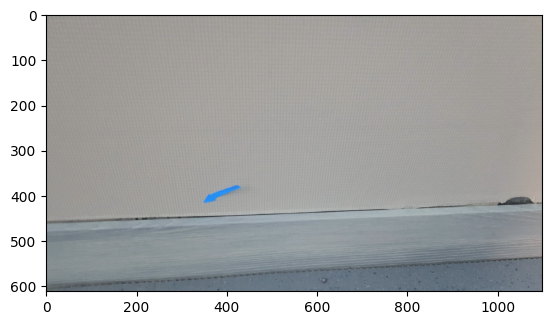

In [13]:
import cv2
from matplotlib import pyplot as plt

img_path = '/content/train/걸레받이수정/0.png'
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()

In [14]:
img_path = '/content/train/걸레받이수정/0.png'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (224, 224))
x = np.zeros((1, 224, 224, 3))
x[0,:,:,0] = img
x = x / 255.0


In [15]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

class Autoencoder():
    def __init__(self):
        self.img_rows = 224
        self.img_cols = 224
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = 'adam'

        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_model(self):
        input_layer = Input(shape=self.img_shape)

        #encoder
        h = Conv2D(32,(3,3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2,2), padding='same')(h)

        h = Conv2D(16,(3,3), activation='relu', padding='same')(h)
        h = MaxPooling2D((2,2), padding='same')(h)

        h = Conv2D(8,(3,3), activation='relu', padding='same')(h)
        h = MaxPooling2D((2,2), padding='same')(h)

        #decoder
        h = Conv2D(8,(3,3), activation='relu', padding='same')(h)
        h = UpSampling2D((2,2))(h)

        h = Conv2D(16,(3,3), activation='relu', padding='same')(h)
        h = UpSampling2D((2,2))(h)

        h = Conv2D(32,(3,3), activation='relu', padding='same')(h)
        h = UpSampling2D((2,2))(h)

        output_layer = Conv2D(3,(3,3), activation='sigmoid', padding='same')(h)
        
        return Model(input_layer, output_layer)

    def train_model(self, x_train, epochs, batch_size=10):
        history = self.autoencoder_model.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
        return history

    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds


In [16]:
ae_model = Autoencoder()
ae_model.train_model(x_train, epochs=200, batch_size=10)

Epoch 1/200
25/25 [==============================] - 16s 79ms/step - loss: 0.6722 - val_loss: 0.6645
Epoch 2/200
25/25 [==============================] - 1s 33ms/step - loss: 0.6572 - val_loss: 0.6632
Epoch 3/200
25/25 [==============================] - 1s 36ms/step - loss: 0.6545 - val_loss: 0.6611
Epoch 4/200
25/25 [==============================] - 1s 35ms/step - loss: 0.6516 - val_loss: 0.6555
Epoch 5/200
25/25 [==============================] - 1s 34ms/step - loss: 0.6436 - val_loss: 0.6460
Epoch 6/200
25/25 [==============================] - 1s 35ms/step - loss: 0.6408 - val_loss: 0.6455
Epoch 7/200
25/25 [==============================] - 1s 31ms/step - loss: 0.6398 - val_loss: 0.6455
Epoch 8/200
25/25 [==============================] - 1s 33ms/step - loss: 0.6385 - val_loss: 0.6432
Epoch 9/200
25/25 [==============================] - 1s 31ms/step - loss: 0.6371 - val_loss: 0.6421
Epoch 10/200
25/25 [==============================] - 1s 31ms/step - loss: 0.6361 - val_loss: 0.641

In [17]:
# Evaluate the model
x_test = load_image(TEST_IMAGES)
preds = ae_model.eval_model(x_test)

10/10 [==============================] - 2s 71ms/step


In [18]:
preds.shape

(307, 224, 224, 3)

In [19]:
import os
import cv2
import numpy as np

# 저장할 폴더 경로
save_dir = '/content/train/걸레받이수정'

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for i in range(len(preds)):
    img = preds[i] * 255.0 # 0~1 범위의 값을 0~255 범위로 변환
    img = img.astype(np.uint8) # 자료형 변환
    file_name = os.path.join(save_dir, f'{i}1.png') # 저장할 파일명 지정
    cv2.imwrite(file_name, img) # 이미지 저장

In [20]:
all_img_list = glob.glob('./train/*/*')

In [21]:
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[2])

In [22]:
df

,img_path,label
0,./train/면불량/2.png,면불량
1,./train/면불량/89.png,면불량
2,./train/면불량/49.png,면불량
3,./train/면불량/27.png,면불량
4,./train/면불량/83.png,면불량
...,...,...
3729,./train/들뜸/22.png,들뜸
3730,./train/들뜸/41.png,들뜸
3731,./train/들뜸/36.png,들뜸
3732,./train/들뜸/53.png,들뜸
